В файле должны быть сохранены результаты запуска на тестовых данных.

Дано: API для данных о футбольных матчах и командах.

Используя kmeans сделать кластеризацию футбольных команд по среднему возрасту игроков команды и количеству проигрышей, результат отобразить в виде точечного графика для случая из 3 и из 5 кластеров.


In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import whiten, kmeans2
from pprint import pprint
import datetime
import math
%matplotlib inline

In [2]:
def call_api(uri, result_key):
    json = {}
    try:
        json = requests.get(uri, headers={'X-Auth-Token': '156809c82dae43b2b24c75429b9140ed'}).json()
        return json[result_key]
    except:
        print(json)
        return None

In [3]:
teams = call_api('http://api.football-data.org/v1/soccerseasons/439/teams', 'teams')
teams

[{'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/496/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/496/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/496'}},
  'code': None,
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/6/63/Rio_Ave_FC.svg',
  'name': 'FC Rio Ave',
  'shortName': 'Rio Ave',
  'squadMarketValue': None},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/503/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/503/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/503'}},
  'code': 'FCP',
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/e/ed/FC_Porto_1922-2005.svg',
  'name': 'FC Porto',
  'shortName': 'Porto',
  'squadMarketValue': None},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/583/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/583/players'},
   'self': {'href

In [4]:
for team in teams:
    players = call_api(team['_links']['players']['href'], 'players')
    fixtures = call_api(team['_links']['fixtures']['href'], 'fixtures')
    goals = 0
    for f in fixtures:
        if team['name'] == f['homeTeamName']:
            goals += f['result']['goalsHomeTeam'] if f['result']['goalsHomeTeam'] else 0
        else:
            goals += f['result']['goalsAwayTeam'] if f['result']['goalsAwayTeam'] else 0
    print('Team "{}", {} players, {} goals'.format(team['name'], len(players), goals))
    team['players'] = players
    team['goals'] = goals
    
pprint(fixtures)
pprint(players)

Team "FC Rio Ave", 27 players, 11 goals
Team "FC Porto", 25 players, 39 goals
Team "Moreirense FC", 28 players, 7 goals
Team "FC Paços de Ferreira", 26 players, 13 goals
Team "Sporting CP", 27 players, 29 goals
Team "Maritimo Funchal", 29 players, 13 goals
Team "CD Tondela", 27 players, 15 goals
Team "SL Benfica", 31 players, 24 goals
Team "Boavista Porto FC", 37 players, 12 goals
Team "FC Arouca", 22 players, 0 goals
Team "Vitoria Setubal", 27 players, 12 goals
Team "C.F. Os Belenenses", 26 players, 13 goals
Team "Vitoria Guimaraes", 25 players, 14 goals
Team "Sporting Braga", 31 players, 19 goals
Team "GD Estoril Praia", 28 players, 8 goals
Team "Feirense", 29 players, 10 goals
Team "Nacional Funchal", 18 players, 0 goals
Team "G.D. Chaves", 25 players, 14 goals
[{'_links': {'awayTeam': {'href': 'http://api.football-data.org/v1/teams/1103'},
             'competition': {'href': 'http://api.football-data.org/v1/competitions/457'},
             'homeTeam': {'href': 'http://api.football

             'competition': {'href': 'http://api.football-data.org/v1/competitions/457'},
             'homeTeam': {'href': 'http://api.football-data.org/v1/teams/1103'},
             'self': {'href': 'http://api.football-data.org/v1/fixtures/163992'}},
  'awayTeamName': 'GD Estoril Praia',
  'date': '2018-02-25T16:00:00Z',
  'homeTeamName': 'G.D. Chaves',
  'matchday': 24,
  'odds': None,
  'result': {'goalsAwayTeam': None, 'goalsHomeTeam': None},
  'status': 'SCHEDULED'},
 {'_links': {'awayTeam': {'href': 'http://api.football-data.org/v1/teams/1103'},
             'competition': {'href': 'http://api.football-data.org/v1/competitions/457'},
             'homeTeam': {'href': 'http://api.football-data.org/v1/teams/1049'},
             'self': {'href': 'http://api.football-data.org/v1/fixtures/163987'}},
  'awayTeamName': 'G.D. Chaves',
  'date': '2018-03-04T16:00:00Z',
  'homeTeamName': 'CD Tondela',
  'matchday': 25,
  'odds': None,
  'result': {'goalsAwayTeam': None, 'goalsHomeTeam': 

In [7]:
def get_age(birth_raw):
    now = datetime.datetime.today()
    birth = datetime.datetime.strptime(birth_raw, '%Y-%m-%d')
    age_raw = now - birth
    age = age_raw.days / 365
    return age

In [8]:
for team in teams:
    players = call_api(team['_links']['players']['href'], 'players')
    fixtures = call_api(team['_links']['fixtures']['href'], 'fixtures')
    age_list = []
    for player in players:
        age = get_age(player['dateOfBirth'])
        age_list.append(age)
    average_age = sum(age_list) / len(age_list)
    loses = 0
    for f in fixtures:
        if team['name'] == f['homeTeamName']:
            if f['result']['goalsAwayTeam'] == f['result']['goalsHomeTeam']:
                continue
            elif f['result']['goalsAwayTeam'] > f['result']['goalsHomeTeam']:
                loses += 1
            else:
                continue
        else:
            if f['result']['goalsAwayTeam'] == f['result']['goalsHomeTeam']:
                continue
            elif f['result']['goalsAwayTeam'] < f['result']['goalsHomeTeam']:
                loses += 1
            else:
                continue
    print('Team "{}", {} average age, {} loses'.format(team['name'], average_age, loses))
    team['average_age'] = average_age
    team['loses'] = loses

Team "FC Rio Ave", 25.520446473871136 average age, 4 loses
Team "FC Porto", 27.04394520547944 average age, 2 loses
Team "Moreirense FC", 24.962524461839536 average age, 6 loses
Team "FC Paços de Ferreira", 26.494731296101158 average age, 5 loses
Team "Sporting CP", 26.272349061390166 average age, 2 loses
Team "Maritimo Funchal", 26.410014170996696 average age, 3 loses
Team "CD Tondela", 26.03074581430745 average age, 5 loses
Team "SL Benfica", 26.23411400795405 average age, 5 loses
Team "Boavista Porto FC", 25.557052943354318 average age, 6 loses
Team "FC Arouca", 27.56973848069739 average age, 0 loses
Team "Vitoria Setubal", 25.86707255200406 average age, 5 loses
Team "C.F. Os Belenenses", 27.075342465753426 average age, 5 loses
Team "Vitoria Guimaraes", 25.359013698630136 average age, 5 loses
Team "Sporting Braga", 24.885903667697743 average age, 3 loses
Team "GD Estoril Praia", 24.360371819960864 average age, 9 loses
Team "Feirense", 25.927066603684462 average age, 6 loses
Team "Nac

In [9]:
team_for_pd = []
for team in teams:
    if team['players']:
        team_for_pd.append({'name': team['name'], 'average_age': team['average_age'], 'loses': team['loses']})
team_for_pd

[{'average_age': 25.520446473871136, 'loses': 4, 'name': 'FC Rio Ave'},
 {'average_age': 27.04394520547944, 'loses': 2, 'name': 'FC Porto'},
 {'average_age': 24.962524461839536, 'loses': 6, 'name': 'Moreirense FC'},
 {'average_age': 26.494731296101158,
  'loses': 5,
  'name': 'FC Paços de Ferreira'},
 {'average_age': 26.272349061390166, 'loses': 2, 'name': 'Sporting CP'},
 {'average_age': 26.410014170996696, 'loses': 3, 'name': 'Maritimo Funchal'},
 {'average_age': 26.03074581430745, 'loses': 5, 'name': 'CD Tondela'},
 {'average_age': 26.23411400795405, 'loses': 5, 'name': 'SL Benfica'},
 {'average_age': 25.557052943354318, 'loses': 6, 'name': 'Boavista Porto FC'},
 {'average_age': 27.56973848069739, 'loses': 0, 'name': 'FC Arouca'},
 {'average_age': 25.86707255200406, 'loses': 5, 'name': 'Vitoria Setubal'},
 {'average_age': 27.075342465753426, 'loses': 5, 'name': 'C.F. Os Belenenses'},
 {'average_age': 25.359013698630136, 'loses': 5, 'name': 'Vitoria Guimaraes'},
 {'average_age': 24.8

In [10]:
teams_pd = pd.DataFrame(team_for_pd)
del teams_pd['name']
teams_pd

,average_age,loses
0,25.520446,4
1,27.043945,2
2,24.962524,6
3,26.494731,5
4,26.272349,2
5,26.410014,3
6,26.030746,5
7,26.234114,5
8,25.557053,6
9,27.569738,0


In [11]:
whitened = whiten(teams_pd.as_matrix())
whitened

array([[ 30.32712814,   1.81307867],
       [ 32.13757222,   0.90653934],
       [ 29.66412358,   2.71961801],
       [ 31.4849159 ,   2.26634834],
       [ 31.22064879,   0.90653934],
       [ 31.38424262,   1.35980901],
       [ 30.93354047,   2.26634834],
       [ 31.17521231,   2.26634834],
       [ 30.3706293 ,   2.71961801],
       [ 32.76239671,   0.        ],
       [ 30.73903995,   2.26634834],
       [ 32.17488304,   2.26634834],
       [ 30.1352901 ,   2.26634834],
       [ 29.57307154,   1.35980901],
       [ 28.94855771,   4.07942702],
       [ 30.81033366,   2.71961801],
       [ 31.49515619,   0.        ],
       [ 32.33565164,   2.71961801]])

In [12]:
centroids, cluster_map = kmeans2(whitened, 5)
centroids, cluster_map

(array([[ 32.25526734,   2.49298318],
        [ 32.13170837,   0.30217978],
        [ 31.30244571,   1.13317417],
        [ 31.02860846,   2.35700228],
        [ 29.83646673,   2.49298318]]),
 array([4, 1, 4, 3, 2, 2, 3, 3, 4, 1, 3, 0, 4, 4, 4, 3, 1, 0]))

In [13]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['m',
 'g',
 'm',
 'y',
 'b',
 'b',
 'y',
 'y',
 'm',
 'g',
 'y',
 'r',
 'm',
 'm',
 'm',
 'y',
 'g',
 'r']

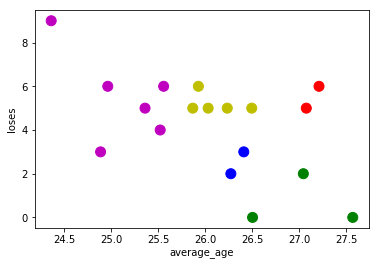

In [14]:
teams_pd.plot.scatter(x='average_age', y='loses', c=colors, s=100)

3 кластера

In [15]:
centroids, cluster_map = kmeans2(whitened, 3)
centroids, cluster_map

(array([[ 31.79266572,   2.37966576],
        [ 31.80000331,   0.63457754],
        [ 30.16685716,   2.46780153]]),
 array([2, 1, 2, 0, 1, 1, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 1, 0]))

In [16]:
colors_map = {0: 'r', 1: 'g', 2: 'b'}
colors = [colors_map[c] for c in cluster_map]
colors

['b',
 'g',
 'b',
 'r',
 'g',
 'g',
 'b',
 'r',
 'b',
 'g',
 'b',
 'r',
 'b',
 'b',
 'b',
 'b',
 'g',
 'r']

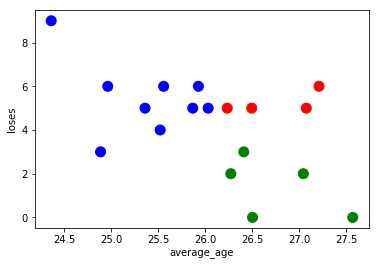

In [17]:
teams_pd.plot.scatter(x='average_age', y='loses', c=colors, s=100)